Импортируем необходимые библиотеки.

In [325]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Прочитаем оба файла в датафреймы.

In [326]:
train = pd.read_csv("data/train_oil.csv")
test = pd.read_csv("data/oil_test.csv")

# Выводим форму датасетов, чтобы понять количество строк и столбцов
print(f"Train dataset shape: {train.shape}")
print(f"Test dataset shape: {test.shape}")

Train dataset shape: (309, 20)
Test dataset shape: (133, 19)


Оценим количество семплов с пропусками.

In [327]:
df_nan = train.loc[:, train.isnull().any()]
# посмотрим процент пропущенных значений
df_nan.isnull().sum() / len(df_nan) * 100

Country        8.737864
Region        12.297735
Basin name    12.297735
Latitude       8.737864
Longitude      9.708738
dtype: float64

Так как пропусков относительно немного, просто удалим семплы с пропусками и убедимся, что пропусков не осталось

In [328]:
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      268 non-null    object 
 1   Reservoir unit                  268 non-null    object 
 2   Country                         268 non-null    object 
 3   Region                          268 non-null    object 
 4   Basin name                      268 non-null    object 
 5   Tectonic regime                 268 non-null    object 
 6   Latitude                        268 non-null    float64
 7   Longitude                       268 non-null    float64
 8   Operator company                268 non-null    object 
 9   Onshore/Offshore                268 non-null    object 
 10  Hydrocarbon type                268 non-null    object 
 11  Reservoir status                268 non-null    object 
 12  Structural setting              268 non-n

Видим, что пропусков больше нет и у нас осталось 268 сэмплов.

Посмотрим на распределение целевой переменной.

C:\Users\dimac\AppData\Local\Temp\ipykernel_29688\2665399700.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Onshore/Offshore', data=y_data, palette='hls')


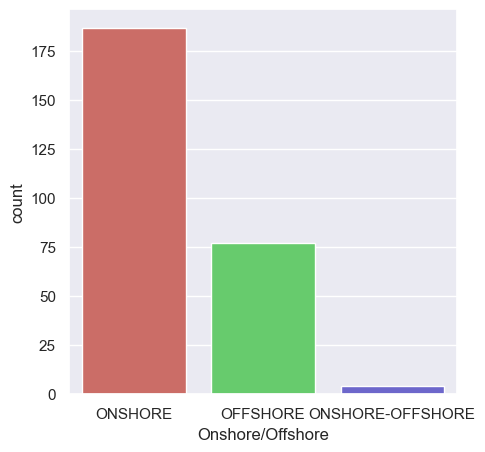

In [329]:
sns.set(rc = {'figure.figsize':(5,5)})
y_data = pd.DataFrame(train['Onshore/Offshore'])
sns.countplot(x='Onshore/Offshore', data=y_data, palette='hls')
plt.show()

In [330]:
train['Onshore/Offshore'].value_counts()

Onshore/Offshore
ONSHORE             187
OFFSHORE             77
ONSHORE-OFFSHORE      4
Name: count, dtype: int64

Видим, что данные очень несбалансированны.

Переведем целевую переменную в числовой формат в соответствии с заданием.

In [331]:
d = {'ONSHORE': 1, 'OFFSHORE': 0, 'ONSHORE-OFFSHORE': 2}

train['Onshore/Offshore'] = train['Onshore/Offshore'].map(d)

Также переведем в числовой формат все нечисловые параметры.

In [332]:

# Список категориальных столбцов, которые нужно закодировать
categ = ['Hydrocarbon type', 'Reservoir status', 'Reservoir period', 'Lithology', 'Tectonic regime', 'Structural setting', 'Field name', 'Reservoir unit', 'Country', 'Region', 'Basin name', 'Operator company']

# Создаем OrdinalEncoder, который заменит категории числами
# Если в тестовой выборке появятся неизвестные категории, они будут заменены на -1
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Обучаем encoder на тренировочных данных и сразу трансформируем train и test
train_encoded = encoder.fit_transform(train[categ])
test_encoded = encoder.transform(test[categ])

# Заменяем старые категориальные столбцы новыми закодированными
train[categ] = train_encoded
test[categ] = test_encoded

Отобразим матрицу корреляций по всем признакам.

<Axes: >

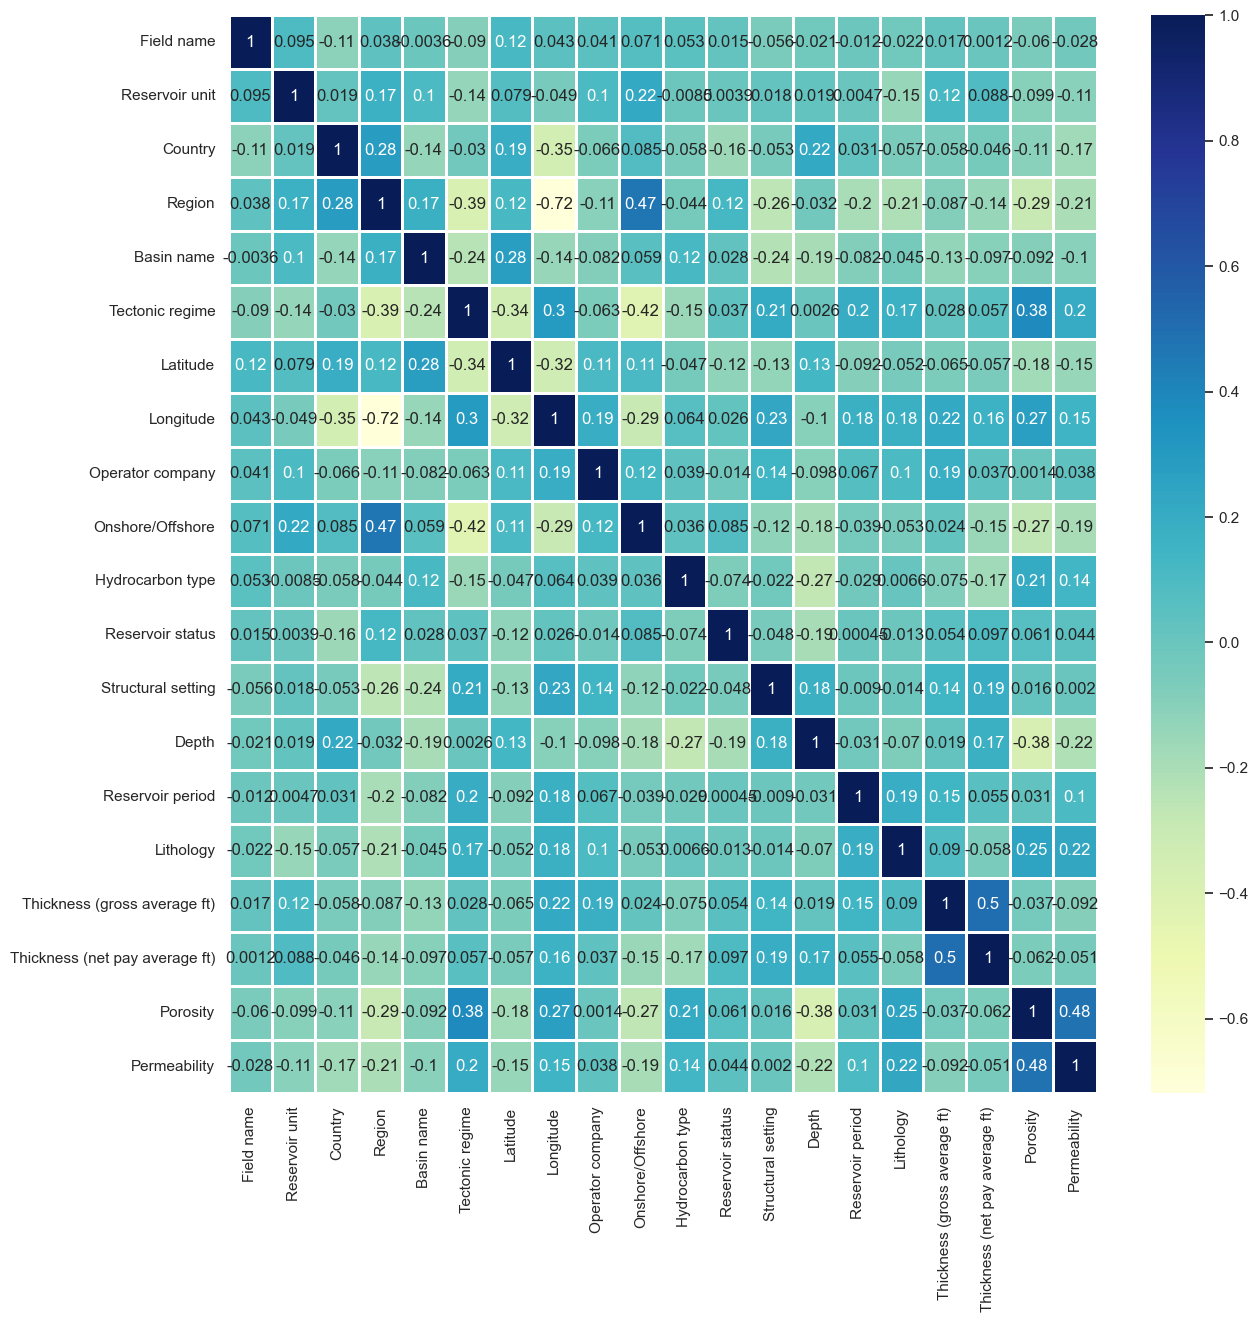

In [333]:
sns.set(rc = {'figure.figsize':(14, 14)})

sns.heatmap(train.corr(numeric_only=True), annot=True, cmap="YlGnBu", linecolor='white', linewidths=1)

Видим, что значимая корреляция только с параметром Region, с другими параметрами - слабая.

Удалим столбцы, у которых коэффициент корреляции с целевой переменной ро модулю меньше 0,1

In [334]:
drop_column = ['Field name', 'Country', 'Basin name', 'Hydrocarbon type', 'Reservoir status', 'Reservoir period', 'Lithology', 'Thickness (gross average ft)']
train = train.drop(drop_column, axis=1)
test = test.drop(drop_column,axis=1)

Разделим датафрейм на параметры и целевую переменную

In [335]:
X = train.drop(columns=['Onshore/Offshore'])
y = train['Onshore/Offshore']

Для устранения дисбаланса в данных проведем оверсемплинг с помощью техники SMOTE

In [336]:
os = SMOTE(random_state=0, k_neighbors=2)

columns = X.columns

os_data_X, os_data_y = os.fit_resample(X, y)
# fit()
# resample()

os_data_X = pd.DataFrame(os_data_X, columns = columns)
os_data_y = pd.DataFrame(os_data_y, columns = ['Onshore/Offshore'])

print(f'Features shape after SMOTE: {os_data_X.shape}')
print(f'Classes distribution after SMOTE:\n{os_data_y.value_counts()}')

Features shape after SMOTE: (561, 11)
Classes distribution after SMOTE:
Onshore/Offshore
0                   187
1                   187
2                   187
Name: count, dtype: int64


Теперь семплов разных категорий одинаковое количество.

Разбиваем данные с учетом стратификации

In [337]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 20% данных в тест
    random_state=42,         # Фиксируем для воспроизводимости
    stratify=y               # Стратифицированное разбиение
)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (214, 11), (214,)
Train dataset size: (54, 11), (54,)


Обучим три модели: Дерево решений, Ближайшие соседи и Случайный лес.
Оценим точность предсказаний

In [338]:
# Создадим модель дерева решений
tree = DecisionTreeClassifier()
knn = KNeighborsClassifier(5)
rf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)

# обучение модели
tree.fit(X_train, y_train)
knn.fit(X_train, y_train)
rf.fit(X_train, y_train)


# предсказание ответов для тестовой выборки
y_pred_tree = tree.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_rf = rf.predict(X_test)

# answers_pred - ответы которые вернула модель для X_test
# y_test - это правильные ответы для X_test
print(f'Accuracy tree: {accuracy_score(y_test, y_pred_tree)}')
print(f'Accuracy knn: {accuracy_score(y_test, y_pred_knn)}')
print(f'Accuracy rf: {accuracy_score(y_test, y_pred_rf)}')

Accuracy tree: 0.7777777777777778
Accuracy knn: 0.7592592592592593
Accuracy rf: 0.8333333333333334


Как видим, лучший результат оказался у алгоритма - Случайный лес, его и будем использовать для предсказания на оцениваемых данных.

Построим матрицы ошибок для всех трех вариантов.

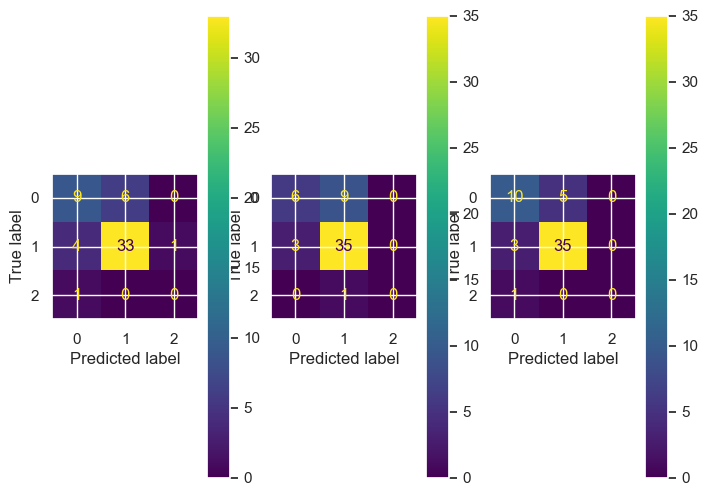

In [339]:
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 3, figsize=(8,6), dpi=100)

display = ConfusionMatrixDisplay(conf_matrix_tree, display_labels=tree.classes_)
display.plot(ax=axes[0])

display = ConfusionMatrixDisplay(conf_matrix_knn, display_labels=knn.classes_)
display.plot(ax=axes[1])

display = ConfusionMatrixDisplay(conf_matrix_rf, display_labels=rf.classes_)
display.plot(ax=axes[2])

Видим, что ни одна из моделей не смогла верно определить минорный класс.

Попробуем подобрать параметр n_estimators

In [340]:
for i in range(1, 21):
    estimators = i * 10
    rf_i = RandomForestClassifier(n_estimators=estimators, criterion='gini', random_state=42)
    rf_i.fit(X_train, y_train)
    y_pred_rf_i = rf_i.predict(X_test)
    print(f'Accuracy rf with {estimators} estimators: {accuracy_score(y_test, y_pred_rf_i)}')

Accuracy rf with 10 estimators: 0.8518518518518519
Accuracy rf with 20 estimators: 0.8518518518518519
Accuracy rf with 30 estimators: 0.8333333333333334
Accuracy rf with 40 estimators: 0.8518518518518519
Accuracy rf with 50 estimators: 0.8703703703703703
Accuracy rf with 60 estimators: 0.8518518518518519
Accuracy rf with 70 estimators: 0.8518518518518519
Accuracy rf with 80 estimators: 0.8518518518518519
Accuracy rf with 90 estimators: 0.8518518518518519
Accuracy rf with 100 estimators: 0.8333333333333334
Accuracy rf with 110 estimators: 0.8333333333333334
Accuracy rf with 120 estimators: 0.8333333333333334
Accuracy rf with 130 estimators: 0.8333333333333334
Accuracy rf with 140 estimators: 0.8333333333333334
Accuracy rf with 150 estimators: 0.8333333333333334
Accuracy rf with 160 estimators: 0.8518518518518519
Accuracy rf with 170 estimators: 0.8518518518518519
Accuracy rf with 180 estimators: 0.8333333333333334
Accuracy rf with 190 estimators: 0.8333333333333334
Accuracy rf with 200 

Лучший результат получился при n_estimators = 50.

NOTE! Несмотря на это, лучшим по оценке на Kaggle оказался изначальный вариант с n_estimators = 100, поэтому дальше используется он.

Делаем предсказание на оцениваемых данных и записываем в файл.

In [341]:
y_test_pred = rf.predict(test)
ans_df = pd.DataFrame(y_test_pred, columns=['Onshore/Offshore '])

ans_df.reset_index(inplace=True)
ans_df.to_csv('submition.csv', index=False)

Скриншот лидерборда.
На 13 месте

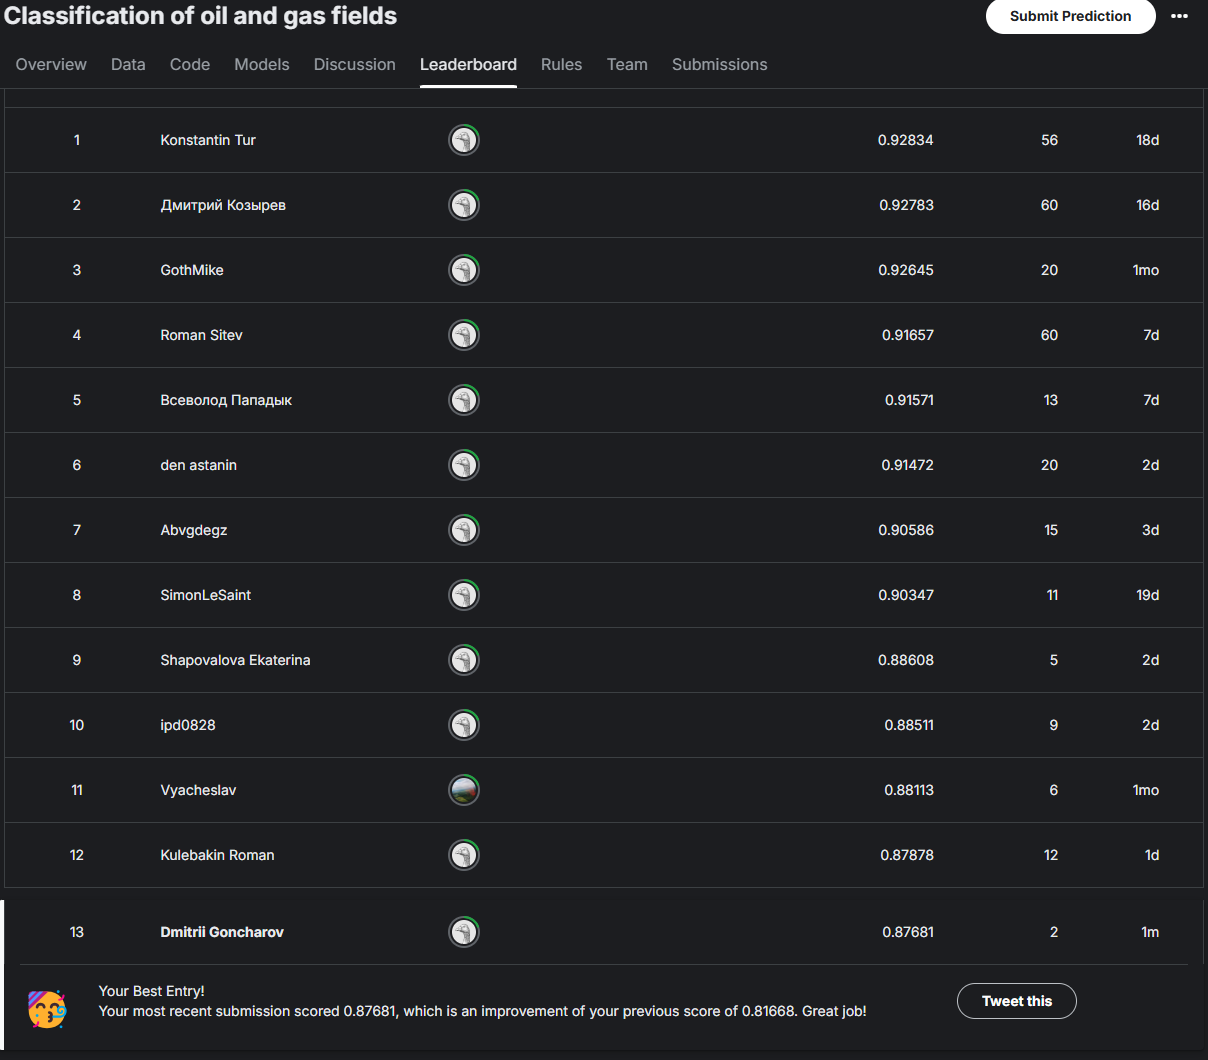